# Copper Energy Demands
This journal documents the energy demands of mining, refining, drawing and recycling of copper for use inside the PV cell. Probably also applies to copper in wiring (not yet considered)

In [11]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8, 4)
cwd = os.getcwd() #grabs current working directory

supportMatfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
baselinesFolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines')

### Mining Energy

In [14]:
cu_mining_raw = pd.read_csv(os.path.join(supportMatfolder+"\energy-input-copper-mining.csv"), index_col='year')
cu_mining_raw.dropna(how='all')

,E_CuMining_kWhpkg,PrctFuel,Source,Notes
year,,,,
1975,15.947000,NaN,"Bravard, J. C., H. B. Flora, and Charles Porta...",mining and milling and flotation of 0.3% Cu or...
1980,6.500000,90.0,"Pitt, C. H., and M. E. Wadsworth. 1980. “Asses...","includes diesel fuel for hauling, and explosives"
1981,10.500000,0.0,"Pitt, C. H., and M. E. Wadsworth. 1980. “Asses...",Grinding and Concentration
2001,1.319000,90.0,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, open pit mine, likely includes transp..."
2002,0.611000,43.0,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, underground mine, likely includes tra..."
2007,3.775417,NaN,"Marsden, John O. “Energy Efficiency & Copper H...",PYRO
2008,7.636778,NaN,"Marsden, John O. “Energy Efficiency & Copper H...",HYDRO with run of mine
2013,3.499902,NaN,"Elshkaki, Ayman, T. E. Graedel, Luca Ciacci, a...","range of 30-90 for ""primary production"", which..."
2014,2.244400,93.0,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, open pit mine, likely includes transp..."


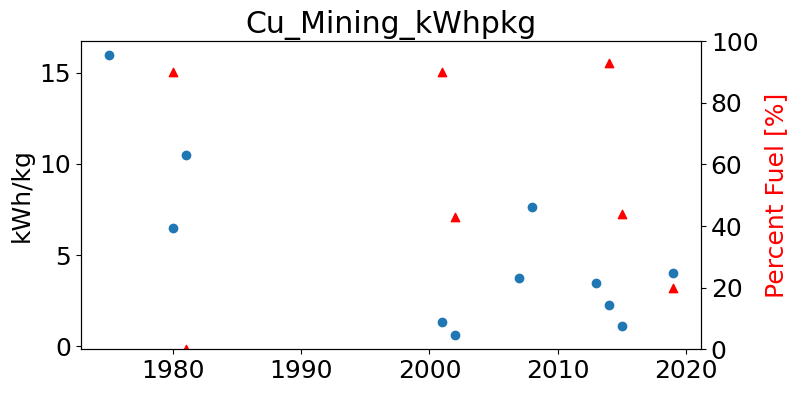

In [38]:
fig, ax1 = plt.subplots()

ax1.scatter(cu_mining_raw.index, cu_mining_raw['E_CuMining_kWhpkg'], marker='o')
ax1.set_ylabel('kWh/kg')

ax2 = ax1.twinx()
ax2.scatter(cu_mining_raw.index, cu_mining_raw['PrctFuel'], marker='^', color='red')
ax2.set_ylabel('Percent Fuel [%]', color='red')
ax2.set_ylim(0,100)

plt.title('Cu_Mining_kWhpkg')
plt.show()


The two highest pre-1990 data points include milling and floation, which start getting into processing of the material (pyro vs hydro). The Marsden data points in 2007-2008 have two mining options, and Lagos et al in 2015 has open pit and underground mining. Both sources may include transportation energies.

To reconcile all the nuanced data points, we will take the average of post-1990 energy data.

The percent fuel differs in Lagos et al between openpit and underground. This is likely due to the inclusion of transportation energy (i.e. openpit which involves more driving is higher fuel). Farjana which excludes transportation is 20% fuels, therefore we will use this.

In [30]:
cu_mining_data = cu_mining_raw.loc[1995:,'E_CuMining_kWhpkg']
cu_mining_avg = cu_mining_data.mean()
cu_minig_prctfuel = 20.0

## PYRO
Pyrometallurgy is the dominant technology for copper mining, although hydrometallurgy market share is growing. Pyro metallurgy is also known as/includes grinding, froth floatation, converting, Smelting, and electrolysis. This final electrorefining step is not to be confused with the hydrometallurgical electrowinning.

This data includes grinding and milling, floatation, smelting, and electrolysis refining.

In [42]:
cu_pyro_raw = pd.read_csv(os.path.join(supportMatfolder+"\energy-input-copper-pyro.csv"), index_col='year')
cu_pyro_raw.dropna(how='all')

,E_Pyro_Cu_kWhpkg,PrctFuel,Source,Notes
year,,,,
1980,8.57,30.0,"Pitt, C. H., and M. E. Wadsworth. 1980. “Asses...","milling (table7.1), smelting, converting, tabl..."
2002,6.34,52.0,"Alvarado, S, P Maldonado, A Barrios, and I Jaq...","concentration, drying, Smelting and electroref..."
2007,9.62,56.0,"Marsden, John O. 2008. “Energy Efficiency & Co...","slide 29, pyro path: HPGR, ball, float, smelt,..."
2008,12.45,53.0,"Marsden, John O. “Energy Efficiency & Copper H...","SAG mill, ball mill, float, gravity, smelt, re..."


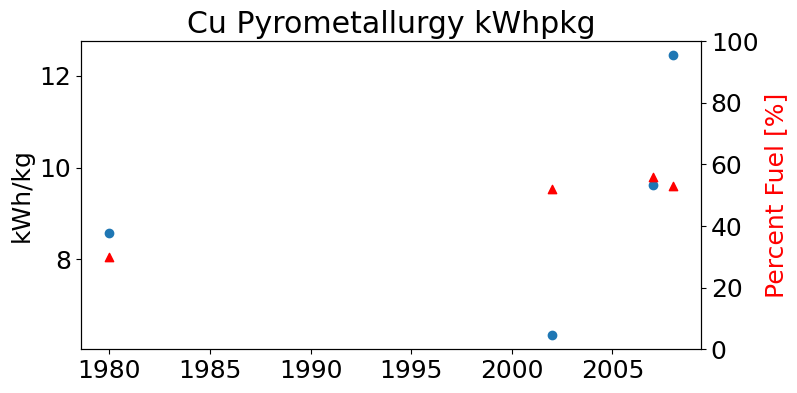

In [43]:
fig, ax1 = plt.subplots()

ax1.scatter(cu_pyro_raw.index, cu_pyro_raw['E_Pyro_Cu_kWhpkg'], marker='o')
ax1.set_ylabel('kWh/kg')

ax2 = ax1.twinx()
ax2.scatter(cu_pyro_raw.index, cu_pyro_raw['PrctFuel'], marker='^', color='red')
ax2.set_ylabel('Percent Fuel [%]', color='red')
ax2.set_ylim(0,100)

plt.title('Cu Pyrometallurgy kWhpkg')
plt.show()

The final two datapoints from Marsden are two different process pathways and therefore represent a range of potential energies for pyrometallurgy. The Alvarado data may not include grinding, and therfore may be low. We will take the average of the Marsden data, and do a linear interpolation from the Pitt 1980.

Fuel fractions are fairly consistent across all data, therefore we will take the average.

In [59]:
cu_pyro = cu_pyro_raw.copy()
cu_pyro.loc[2002] = np.nan
cu_pyro_avg_2007 = cu_pyro.loc[2007:2008,'E_Pyro_Cu_kWhpkg'].mean()
cu_pyro.loc[2007:2008,'E_Pyro_Cu_kWhpkg'] = cu_pyro_avg_2007

cu_pyro_filled = cu_pyro.interpolate()
cu_pyro_final = cu_pyro_filled.loc[1995:,'E_Pyro_Cu_kWhpkg':'PrctFuel']

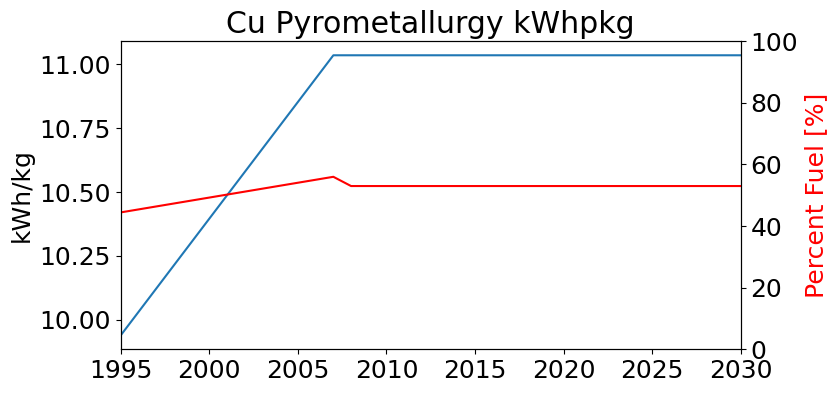

In [61]:
#cu_pyro_final
fig, ax1 = plt.subplots()

ax1.plot(cu_pyro_final.index, cu_pyro_final['E_Pyro_Cu_kWhpkg'])
ax1.set_ylabel('kWh/kg')
ax1.set_xlim(1995,2030)

ax2 = ax1.twinx()
ax2.plot(cu_pyro_final.index, cu_pyro_final['PrctFuel'], color='red')
ax2.set_ylabel('Percent Fuel [%]', color='red')
ax2.set_ylim(0,100)

plt.title('Cu Pyrometallurgy kWhpkg')
plt.show()

## HYDRO

In [66]:
cu_hydro_raw = pd.read_csv(os.path.join(supportMatfolder+"\energy-input-copper-hydro.csv"), index_col='year')
cu_hydro_raw.dropna(how='all')

,E_hydro_Cu_kWhpkg,PrctFuel,Source,Notes
year,,,,
1980,12.840,0.0,"Pitt, C. H., and M. E. Wadsworth. 1980. “Asses...",omitting roast/sulfite reduction and cymet
2002,3.100,9.7,"Alvarado, S, P Maldonado, A Barrios, and I Jaq...","table 4, electrowinning"
2008,4.160,40.3,"Marsden, John O. “Energy Efficiency & Copper H...","heap leach, sx ew"
2009,3.350,NaN,"Bleiwas, Donald. 2011. “Estimates of Electrici...","Table 13, per tonne Cu, includes Secondary cru..."
2015,3.325,2.0,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","only considers hydro in 2015 in Chile, fig. 3 ..."


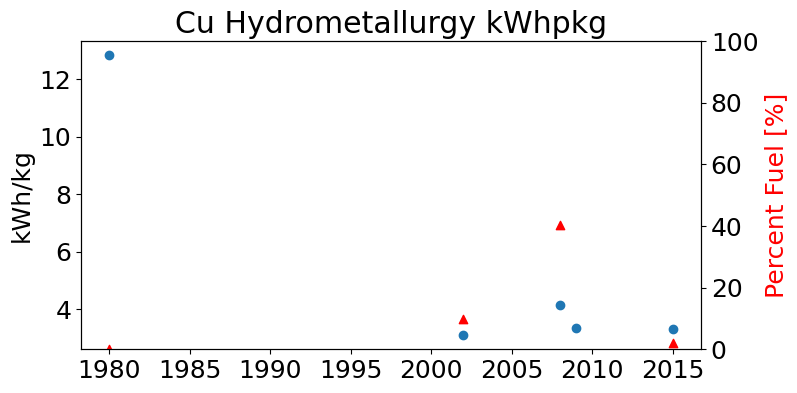

In [67]:
fig, ax1 = plt.subplots()

ax1.scatter(cu_hydro_raw.index, cu_hydro_raw['E_hydro_Cu_kWhpkg'], marker='o')
ax1.set_ylabel('kWh/kg')

ax2 = ax1.twinx()
ax2.scatter(cu_hydro_raw.index, cu_hydro_raw['PrctFuel'], marker='^', color='red')
ax2.set_ylabel('Percent Fuel [%]', color='red')
ax2.set_ylim(0,100)

plt.title('Cu Hydrometallurgy kWhpkg')
plt.show()

## Import Market share of Pyro vs Hydro Metallurgy

In [16]:
#import marketshare
mrktshr_pyrohydro_raw = pd.read_excel(os.path.join(supportMatfolder+"\energy-inputs-copper-maths.xlsx"),
              sheet_name='pyrovshydro', index_col=0, header=[0])

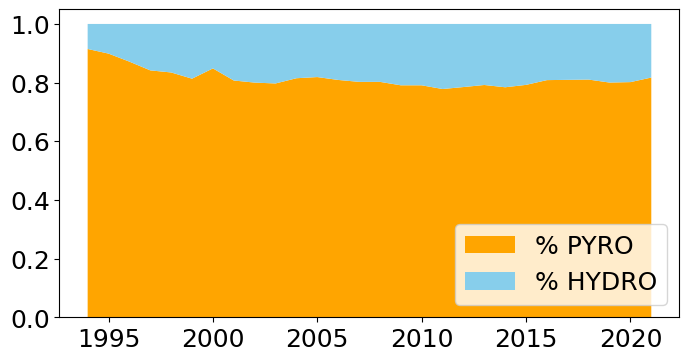

In [17]:
mrktshr_pyrohydro = mrktshr_pyrohydro_raw[['% PYRO','% HYDRO']]

plt.stackplot(mrktshr_pyrohydro.index, mrktshr_pyrohydro['% PYRO'], mrktshr_pyrohydro['% HYDRO'], colors=['orange','skyblue'])
plt.legend(mrktshr_pyrohydro.columns, loc='lower right')

In [18]:
pyro_mrktshr_CED = mrktshr_pyrohydro['% PYRO']*CED_pyro
pyro_mrktshr_CED[0:5]

“The World Copper Factbook 2022.” 2022, 68.
1994    11.727135
1995    11.524796
1996    11.173422
1997    10.791721
1998    10.700371
Name: % PYRO, dtype: float64

In [19]:
hydro_mrktshr_CED = mrktshr_pyrohydro['% HYDRO']*CED_hydro
hydro_mrktshr_CED[0:5]

“The World Copper Factbook 2022.” 2022, 68.
1994    1.439028
1995    1.705181
1996    2.167372
1997    2.669453
1998    2.789612
Name: % HYDRO, dtype: float64

In [20]:
11.727135+1.439028

13.166163000000001

(10.0, 20.0)

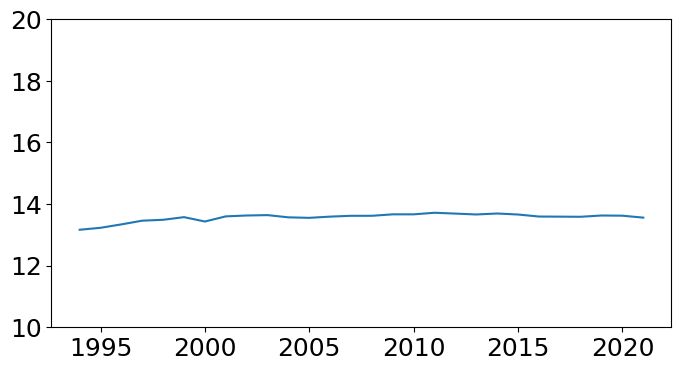

In [21]:
CED_mrktshr = pd.DataFrame(pyro_mrktshr_CED+hydro_mrktshr_CED)
plt.plot(CED_mrktshr)
plt.ylim(10,20)

Now in 2050 we have two projections of energy demand in 2050. There is another projection from Elshkaki 2016, but this is older and nearly double the other two estimates. We will average the two 2050 projection estimates and interpolate to that value.

In [22]:
CED_Cu_tofill = pd.concat([CED_mrktshr.loc[1995:],cu_CED_raw.loc[2022:,'CED_Cu_kWhpkg']])
#create the new 2050 value
CED_2050_mean = cu_CED_raw.loc[2022:,'CED_Cu_kWhpkg'].dropna(how='all').mean()
#CED_2050_mean
#set the 2049 to nan and 2050 to the new mean
CED_Cu_tofill.loc[2049]=np.nan
CED_Cu_tofill.loc[2050]=CED_2050_mean
#interpolate
CED_Cu_filled = CED_Cu_tofill.interpolate()

(10.0, 20.0)

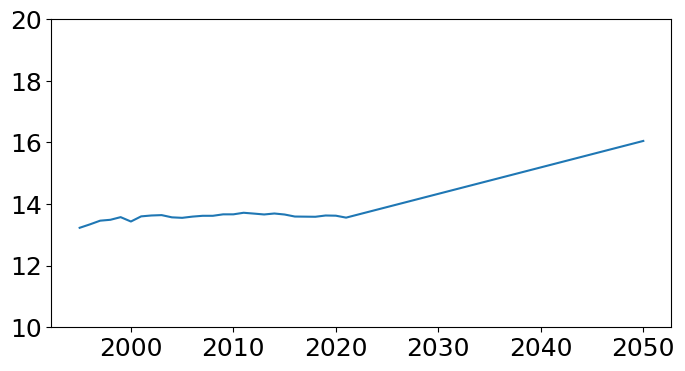

In [23]:
plt.plot(CED_Cu_filled)
plt.ylim(10,20)

### Add the Energy to turn Cu cathode in to Cu wire

In [24]:
cu_wireDraw_raw = pd.read_csv(os.path.join(supportMatfolder+"\energy-input-copper-wireDraw.csv"), index_col='year')
cu_wireDraw_raw.dropna(how='all')

,E_wireDraw_kWhpkg,PrctFuel,Source,Notes
year,,,,
1995,2.778000,NaN,"G. J. M. Phylipsen and E. A. Alsema, “Environm...","Estimate, 18 GJ/ton to melt Cu, only need to s..."
2010,0.230944,NaN,"Bumby, Sarah, Ekaterina Druzhinina, Rebe Feral...","LCA of grid distribution system, Supplemental ..."
2012,14.698514,NaN,“The Environmental Profile of Copper Products ...,"PED from LCA from EU copper institute, include..."
2018,0.169952,NaN,"Rodriguez-Alabanda, O., P. E. Romero, G. Guerr...",are selling a software optimizing wire pulling...
2021,2.160795,NaN,"Yu, Huiling, Hao Sun, Weixia Liu, Ruiqiu Zhang...",Table 1 updrawing casting machine + big drawin...


In [25]:
#subtract the average historical CED of Cu from the 2012 data to get just wire pulling part
adj_wire = cu_wireDraw_raw.loc[2012,'E_wireDraw_kWhpkg']-CED_mrktshr.mean() #using the historical with marketshare hydro/pyro wtd
cu_wireDraw_raw.loc[2012,'E_wireDraw_kWhpkg'] = adj_wire[0]
adj_wire

0    1.131648
dtype: float64

In [26]:
cu_wireDraw_raw.dropna(how='all')

,E_wireDraw_kWhpkg,PrctFuel,Source,Notes
year,,,,
1995,2.778000,NaN,"G. J. M. Phylipsen and E. A. Alsema, “Environm...","Estimate, 18 GJ/ton to melt Cu, only need to s..."
2010,0.230944,NaN,"Bumby, Sarah, Ekaterina Druzhinina, Rebe Feral...","LCA of grid distribution system, Supplemental ..."
2012,1.131648,NaN,“The Environmental Profile of Copper Products ...,"PED from LCA from EU copper institute, include..."
2018,0.169952,NaN,"Rodriguez-Alabanda, O., P. E. Romero, G. Guerr...",are selling a software optimizing wire pulling...
2021,2.160795,NaN,"Yu, Huiling, Hao Sun, Weixia Liu, Ruiqiu Zhang...",Table 1 updrawing casting machine + big drawin...


None of these are very large. We will average these values to estimate the wire drawing requirements, then add it to the CED to get a MFGing of virgin Cu. This value will also be added to the recycling processing requirements below.

In [27]:
e_wireDraw = cu_wireDraw_raw['E_wireDraw_kWhpkg'].mean()
e_wireDraw

1.2942678788092012

In [28]:
CED_Cu_virgin = round(CED_Cu_filled+e_wireDraw,2)
CED_Cu_virgin.to_csv(os.path.join(supportMatfolder+'\output_energy_Cu_Mfging.csv'))

# Cu Recycling

In [35]:
cu_recycle_raw = pd.read_csv(os.path.join(supportMatfolder+"\energy-input-copper-recycle.csv"), index_col='year')
cu_recycle_raw.dropna(how='all')

,E_recycleCu_kWhpkg,Source,Notes
year,,,
1975,1.255000,"Bravard, J. C., H. B. Flora, and Charles Porta...","11% of virgin req energy, 98% purity"
1978,5.826389,"Rankin, John. 2012. “Energy Use in Metal Produ...","embodied energy of 2ndary production, multiple..."
1979,1.231108,Kusik and Kenahan 1978,No1 or new scrap
1980,5.580122,Kusik and Kenahan 1978,No 2 scrap
1981,13.706906,Kusik and Kenahan 1978,Low grade copper bearing scrap
1982,2.290769,Kusik and Kenahan 1978,Brass and Bronze scrap
2008,1.749951,"Elshkaki, Ayman, T. E. Graedel, Luca Ciacci, a...",citing Grimes et al 2008
2009,4.166655,"Wang, Tong, Peter Berrill, Julie B. Zimmerman,...","Table S6, comparing other sources, have differ..."
2010,0.499999,"Nuss, Philip, and Matthew J. Eckelman. 2014. “...","electronic scrap, Ecoinvent 2.2 data (2010)"


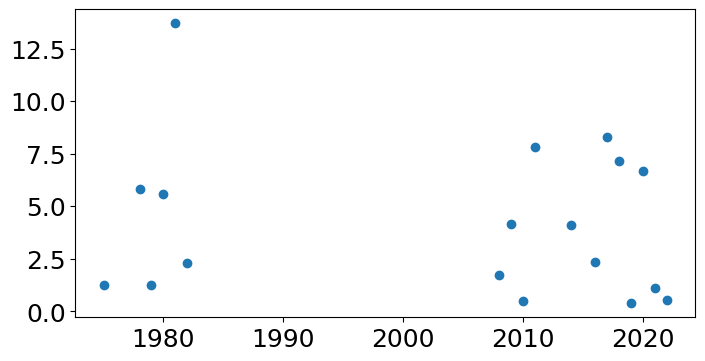

In [36]:
plt.scatter(cu_recycle_raw.index, cu_recycle_raw['E_recycleCu_kWhpkg'])

We will use Dong et al 2022, based on their inventory in their supplemental information. We will use the WEEE specific data (2018), CED, which account for processing e-waste (which is the closest approximation to a PV module), then smelts and refines the copper.

I cannot find any information on low purity copper recycling, therefore, we will assume all this copper gets recycled to high quality (i.e. LQ recycling will be all energy). The energy associated with HQ will be the wire drawing energy (calculated above). We will also assume the same fuel fraction for recycling as primary since it is using the same smelting processes.